<a href="https://colab.research.google.com/github/aliakbarbadri/natural-language-inference/blob/master/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow_addons as tfa

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

# Load and Preprocess the data

In [2]:
source = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/hypotheses_train.pickle?raw=true')
target = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/premises_train.pickle?raw=true')

In [3]:
print(source[0])
print(target[0])

A person is outdoors , on a horse .
A person on a horse jumps over a broken down airplane .


In [4]:
lines_main = pd.DataFrame(
    {'source': source,
     'target': target
     })

In [5]:
lines_main.shape

(183416, 2)

In [6]:
lines = lines_main[:50000]

In [7]:
lines.shape

(50000, 2)

In [8]:
# Lowercase all characters
lines.source=lines.source.apply(lambda x: x.lower())
lines.target=lines.target.apply(lambda x: x.lower())

# Remove quotes
lines.source=lines.source.apply(lambda x: re.sub("'", '', x))
lines.target=lines.target.apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.source=lines.source.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.source=lines.source.apply(lambda x: x.translate(remove_digits))
lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.source=lines.source.apply(lambda x: x.strip())
lines.target=lines.target.apply(lambda x: x.strip())
lines.source=lines.source.apply(lambda x: re.sub(" +", " ", x))
lines.target=lines.target.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.target = lines.target.apply(lambda x : 'START_ '+ x + ' _END')

lines.sample(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,source,target
29546,the male is wearing a cover and using a musica...,START_ a man with a camouflage hat on playing ...
13741,the man is standing,START_ a man stands in a mobile food stand loo...
16934,the young man who is mixing drinks is wearing ...,START_ a young man with a white hat and a blac...
8070,a group of men and women are outside,START_ group of three men and women in their l...
2497,the white dogs look at a llama,START_ the white dogs look curiously at the bl...
30685,a group of men are on the shore,START_ a group of men enjoying their selves on...
38056,the men wore white clothing,START_ six men dressed in white clothing seem ...
42005,the two small dogs are going after a bigger dog,START_ two small dogs follow a larger dog with...
27685,the vendor is making money outside,START_ the donut vendor is making money at the...
39759,there is a person in the desert,START_ a hiker dressed in a tshirt and shorts ...


In [9]:
all_words_source=set()
for line in lines.source:
    for word in line.split():
        if word not in all_words_source:
            all_words_source.add(word)

all_words_target=set()
for line in lines.target:
    for word in line.split():
        if word not in all_words_target:
            all_words_target.add(word)

In [10]:
lenght_list=[]
for l in lines.source:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

lenght_list=[]
for l in lines.target:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

max_length_src, max_length_tar

(43, 80)

In [11]:
input_words = sorted(list(all_words_source))
target_words = sorted(list(all_words_target))

num_encoder_tokens = len(all_words_source)+1
num_decoder_tokens = len(all_words_target)+1

num_encoder_tokens, num_decoder_tokens

(8692, 11413)

In [12]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [13]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [14]:
lines = shuffle(lines)
# lines.head(10)

In [15]:
# Train - Test Split
X, y = lines.source, lines.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((40000,), (10000,))

In [16]:
# X_train.to_pickle('X_train.pkl')
# X_test.to_pickle('X_test.pkl')

In [17]:
def generate_batch(X = X_train, y = y_train, batch_size = 64):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Model

In [38]:
latent_dim = 256

In [39]:
class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size):
        super(LuongAttention, self).__init__()
        self.wa = tf.keras.layers.Dense(rnn_size)
    def call(self, decoder_output, encoder_output):
        # Dot score: h_t (dot) Wa (dot) h_s
        # encoder_output shape: (batch_size, max_len, rnn_size)
        # decoder_output shape: (batch_size, 1, rnn_size)
        # score will have shape: (batch_size, 1, max_len)
        score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)
         # alignment vector a_t
        alignment = tf.nn.softmax(score, axis=2)
        # context vector c_t is the average sum of encoder output
        context = tf.matmul(alignment, encoder_output)
        return context, alignment

In [40]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(1024, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [41]:
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)(decoder_inputs)
decoder_lstm = LSTM(1024, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)

In [42]:
attention = LuongAttention(1024)
context, alignment = attention(decoder_outputs, encoder_outputs)

In [43]:
decoder_outputs = tf.concat([tf.squeeze(context, 1), tf.squeeze(decoder_outputs, 1)], 1)
wc = tf.keras.layers.Dense(1024, activation='tanh')(decoder_outputs)
logits = tf.keras.layers.Dense(num_decoder_tokens)(wc)

model = Model([encoder_inputs, decoder_inputs], logits)

In [44]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

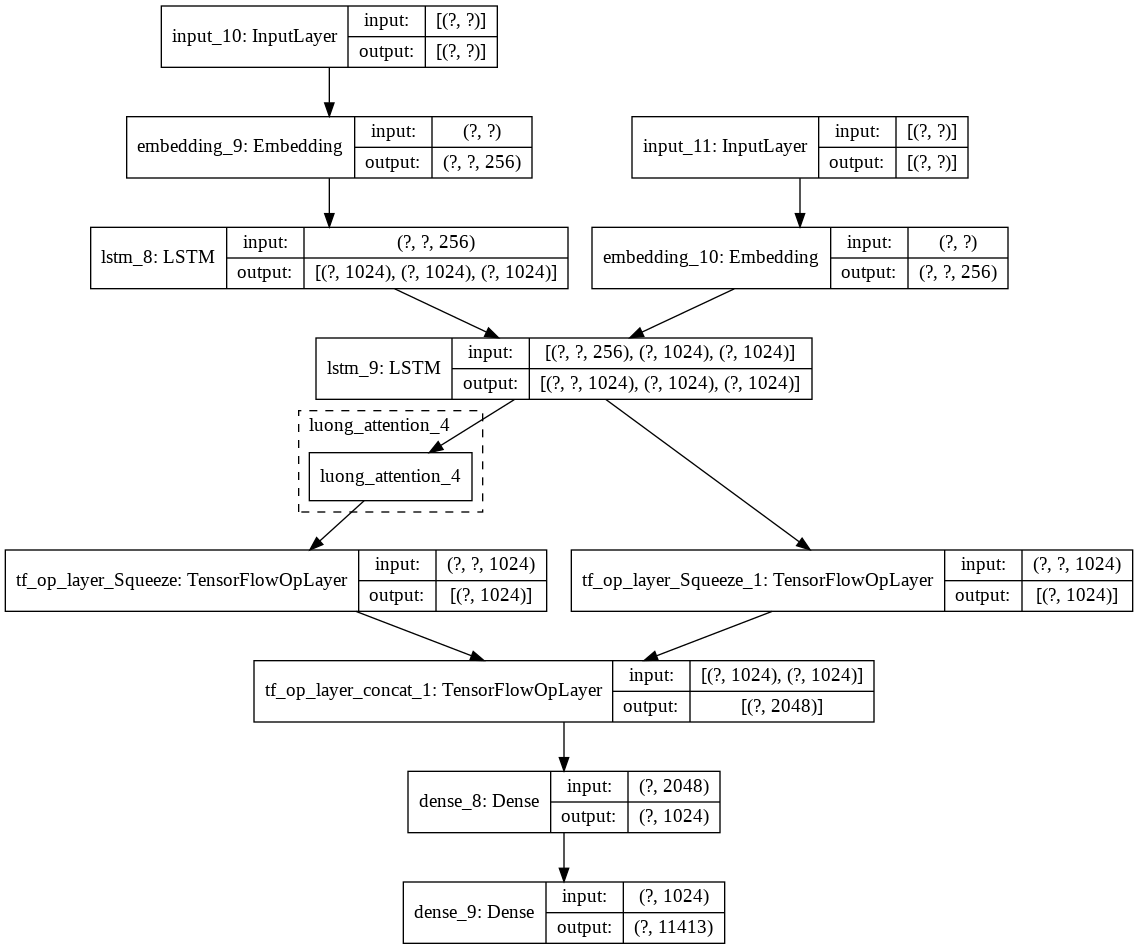

In [45]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [46]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 10

In [ ]:
history = model.fit(generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/10


In [ ]:
model = keras.models.load_model('attentio.h5')

In [ ]:
model.save('attention.h5')

In [ ]:
# storing the attention weights to plot later on
attention_weights = tf.reshape(attention_weights, (-1, ))
attention_plot[t] = attention_weights.numpy()

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Loss and Acc. graph

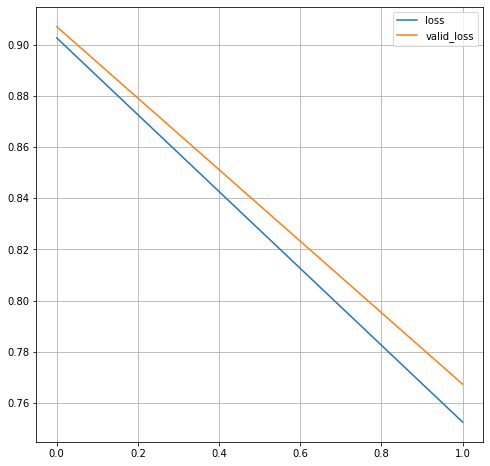

In [ ]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

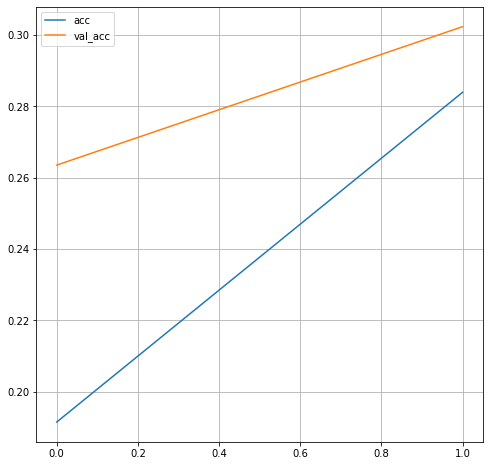

In [ ]:
pd.DataFrame({'acc':history.history['acc'],
              'val_acc':history.history['val_acc']
              }).plot(figsize=(8, 8))
plt.grid(True)


# Model Evaluation

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

In [ ]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input:', X_test[k:k+1].values[0])
print('Actual:', y_test[k:k+1].values[0][6:-4])
print('Predicted:', decoded_sentence[:-4])

Input: a man is getting help with fitness
Actual:  a man getting help with fitness from a physical trainer in a gym 
Predicted:  a man in a white shirt is working on a stage 


In [ ]:
print(y_test[k:k+1].values[0])
print(y_test[k:k+1].values[0][6:-4])
print()
print(decoded_sentence)
print(decoded_sentence[:-4])

START_ a man getting help with fitness from a physical trainer in a gym _END
 a man getting help with fitness from a physical trainer in a gym 

 a man in a white shirt is working on a stage _END
 a man in a white shirt is working on a stage 


# Blue

https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213

# 